In [1]:
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from read_telega_dump import telega_dump_to_pandas


tlg_group_id = -1001688539638 
# telegram group id, can be taken from "copy message link"  in desctop telegram

### we can use either of the cells below to load data from dump. 
For data preparation we can leverage methods from test_read_telega.py module


In [2]:
dump_path = r"D:\test_data\ChatExport_2024-03-14\result.json"
df = telega_dump_to_pandas(dump_path=dump_path)
# note: for data, taken from "export chat history", we do not have number of reactions 


In [3]:
tlg_group_id = -1001688539638
file_path = rf'data\chat{tlg_group_id}.parquet.gzip'
df =pd.read_parquet(file_path)
df.shape

(144835, 10)

In [55]:
df.dtypes

is_question                       bool
user_name                       object
msg_text                        object
msg_len                          int64
reply_to_msg_id                float64
react_cnt                        int64
user_id                          int64
msg_id                           int64
msg_date           datetime64[ns, UTC]
msg_month_key                 category
dtype: object

### Overall statistics

In [65]:
df['dummi'] = 1 # there should be less ugly way to get different aggegations without grouping
agg_df = df.groupby('dummi').aggregate({'msg_id':'count','msg_date':['min','max'], 'user_id': 'nunique'}).reset_index()
msgs_cnt = agg_df[( 'msg_id', 'count')][0]
min_date = agg_df[('msg_date', 'min')][0]
max_date = agg_df[('msg_date', 'max')][0]
number_of_days = (max_date-min_date).days
unique_users =  agg_df[('user_id', 'nunique')][0]
del df['dummi'] 
cols = ["Metric name", "Value"]
dt_format = "%Y-%m-%d"
d_report = [
    {cols[0]: "Number or messages", cols[1]: msgs_cnt},
    {cols[0]: "Date interval", cols[1]: f'from {min_date.strftime(dt_format)} to {max_date.strftime(dt_format)}' },
    {cols[0]: "Users count", cols[1]: unique_users },
    {cols[0]: "Avg messages per day", cols[1]: round(msgs_cnt/number_of_days , 1) },
    ]
pd.DataFrame.from_dict(d_report)






,Metric name,Value
0,Number or messages,144835
1,Date interval,from 2022-03-05 to 2024-03-20
2,Users count,1313
3,Avg messages per day,194.1


### assign date range if you want to restict dataset to some particular period for futher analysis, or just ignore the cell below 

In [57]:
tm_zn = 'Europe/Istanbul'
dt_range = (pd.Timestamp(year=2022, month=2, day=23, tz=tm_zn), pd.Timestamp(datetime.now(), tz=tm_zn))           
number_of_days = (dt_range[1]-dt_range[0]).days
df = df[df.msg_date.between(*dt_range)]


### aggregations by date

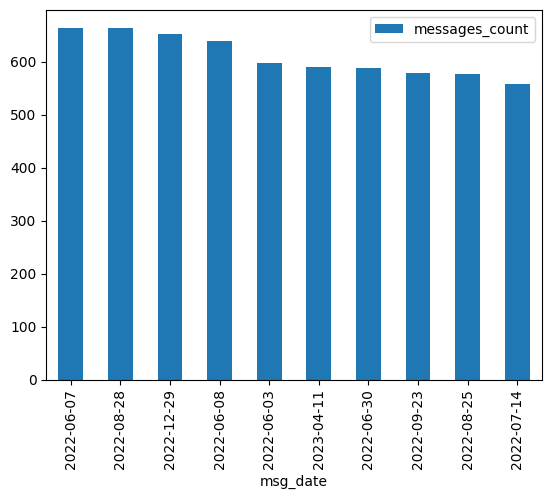

In [4]:
df_aggr = df.groupby(df.msg_date.dt.date).size().sort_values(ascending=False).reset_index(name='messages_count')
df_aggr[0:10].plot(x='msg_date', y='messages_count',kind='bar')
plt.show()

<Axes: >

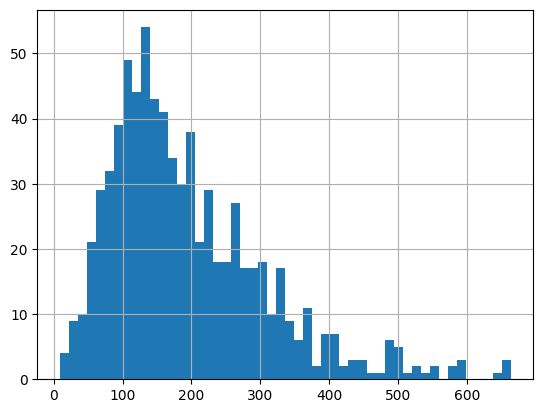

In [59]:
# Visualize the distribution of count of messages per day
df_aggr.messages_count.hist(bins=50)

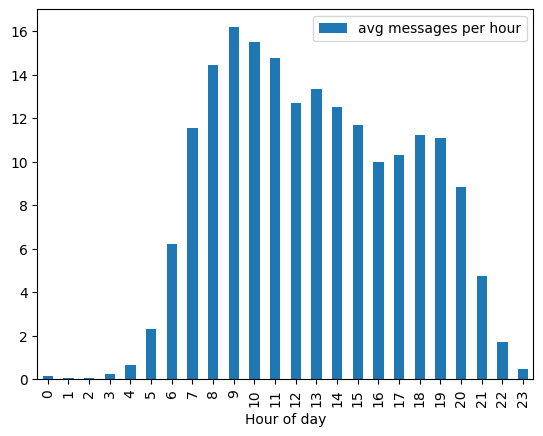

In [60]:
df_aggr = df.groupby(df.msg_date.dt.hour).size().reset_index(name='messages_count')
df_aggr['messages_count'] =  round(df_aggr['messages_count']/number_of_days, 2)
df_aggr = df_aggr.rename(columns={'msg_date': 'Hour of day', 'messages_count': 'avg messages per hour'})
df_aggr[0:24].plot(x='Hour of day', y='avg messages per hour',kind='bar')
plt.show()

### Aggregations by user

Choose metric to play around
- Number of messages
- Length of message
- Number of reactions 
- Number of questions
- Number of answers to some questions


Aggegations

In [72]:
aggs = {'msg_id':'count',
        'msg_date':['min','max'],
        'react_cnt': 'sum',
        'msg_len': 'mean',
        "is_question": 'sum'
        }
agg_df = df.groupby('user_id').aggregate(aggs).reset_index()
agg_df.columns


MultiIndex([(    'user_id',      ''),
            (     'msg_id', 'count'),
            (   'msg_date',   'min'),
            (   'msg_date',   'max'),
            (  'react_cnt',   'sum'),
            (    'msg_len',  'mean'),
            ('is_question',   'sum')],
           )

In [73]:
# flattening of column MultiIndex
if  isinstance(agg_df.columns, pd.MultiIndex):
    agg_df.columns = ['_'.join(col).rstrip('_') if col[1] else col[0] for col in agg_df.columns]
agg_df.columns


Index(['user_id', 'msg_id_count', 'msg_date_min', 'msg_date_max',
       'react_cnt_sum', 'msg_len_mean', 'is_question_sum'],
      dtype='object')

### Calculations for different metrics

In [74]:
# calculations

msg_cnt_s = agg_df['msg_id_count']

agg_df['activity_days'] = (agg_df ['msg_date_max'] - agg_df ['msg_date_min']).dt.days+1
agg_df['reactions_per_mess'] = agg_df['react_cnt_sum']/msg_cnt_s
agg_df['mess_per_day'] = msg_cnt_s/agg_df['activity_days']
agg_df['%_of_questions'] = agg_df['is_question_sum']/msg_cnt_s
agg_df.head(10)

,user_id,msg_id_count,msg_date_min,msg_date_max,react_cnt_sum,msg_len_mean,is_question_sum,activity_days,reactions_per_mess,mess_per_day,%_of_questions
0,20199,10,2022-04-06 14:09:06+00:00,2022-04-16 11:59:02+00:00,1,43.300000,4,10,0.100000,1.000000,0.400000
1,59814,5,2022-04-12 19:50:18+00:00,2022-05-16 21:37:42+00:00,4,139.400000,0,35,0.800000,0.142857,0.000000
2,249764,1,2023-11-11 09:20:32+00:00,2023-11-11 09:20:32+00:00,1,21.000000,0,1,1.000000,1.000000,0.000000
3,259478,205,2022-10-14 17:58:11+00:00,2023-04-15 11:10:23+00:00,51,67.263415,34,183,0.248780,1.120219,0.165854
4,268725,235,2022-06-09 12:19:08+00:00,2022-12-21 16:09:06+00:00,59,53.548936,67,196,0.251064,1.198980,0.285106
5,285150,1,2022-05-08 12:05:18+00:00,2022-05-08 12:05:18+00:00,0,202.000000,1,1,0.000000,1.000000,1.000000
6,345383,4,2022-11-10 11:14:12+00:00,2023-02-06 21:51:33+00:00,0,90.250000,3,89,0.000000,0.044944,0.750000
7,361816,8,2022-06-30 11:16:33+00:00,2022-07-13 08:05:39+00:00,1,67.500000,3,13,0.125000,0.615385,0.375000
8,555411,1218,2022-05-22 06:36:08+00:00,2024-03-19 12:01:52+00:00,453,89.133005,304,668,0.371921,1.823353,0.249589
9,713052,4,2022-11-07 07:25:20+00:00,2023-09-01 17:06:07+00:00,1,448.250000,0,299,0.250000,0.013378,0.000000


In [75]:
rank_metricks = [
     'msg_id_count',
     'msg_len_mean',
     'reactions_per_mess',
     '%_of_questions',  
]
for m in rank_metricks:
   agg_df['rn_' + m] = agg_df[m].rank(ascending=False).astype('int')
   

In [76]:
agg_df.head(10)
agg_df.columns


Index(['user_id', 'msg_id_count', 'msg_date_min', 'msg_date_max',
       'react_cnt_sum', 'msg_len_mean', 'is_question_sum', 'activity_days',
       'reactions_per_mess', 'mess_per_day', '%_of_questions',
       'rn_msg_id_count', 'rn_msg_len_mean', 'rn_reactions_per_mess',
       'rn_%_of_questions'],
      dtype='object')

#### JOIN to user names

In [93]:
users_dump = r'data\participants.json'
usrs_df = pd.read_json(users_dump)
agg_df = pd.merge(usrs_df, agg_df , on='user_id')
usrs_df

,user_id,username,first_name
0,52026345,Kotyakleo,Ekaterina
1,5311571520,ipek_tr,Marina auto antalya
2,881257459,Elmanov_Anton,Elmanov
3,1182459450,dklmn,Dmitrii
4,476212736,iDanissimo,Даниил
...,...,...,...
1059,277069446,etrishch,Evgeniia
1060,550837985,El_Martyno,Elena
1061,570762314,martynov_an,Andrei
1062,252781106,amigodeadfriend,Iana


In [80]:
agg_df['user_name_hash'] = agg_df['username'].apply(hash)
# to obfuscate private data as user namesuser_name_hash

### Playing around with cumulative sums
Trying to prove the claim "10 % of users makes 90 % of messages"

In [59]:
agg_df.sort_values( 'msg_id_count', ascending=False, inplace=True)
agg_df.reset_index(drop=True, inplace=True)
# then calculate the rolling sum
agg_df['msg_cnt_cs'] = agg_df['msg_id_count'].cumsum()
total_sum =  agg_df['msg_id_count'].sum()
users_cnt = agg_df['user_id'].count()
agg_df['msg_cnt_cs %'] = (agg_df['msg_cnt_cs']*100 / total_sum).astype(int)
agg_df['user_cnt %'] = (agg_df['rn_msg_id_count'] *100 / users_cnt)
print(f'{total_sum=}; {users_cnt=}')



total_sum=123504; users_cnt=770


In [64]:
agg_df[['user_id','user_name_hash', 'msg_id_count', 'user_cnt %', 'msg_cnt_cs %']][agg_df['user_cnt %']<=10]

,user_id,user_name_hash,msg_id_count,user_cnt %,msg_cnt_cs %
0,52026345,2317519114550067144,12723,0.129870,10
1,190329073,-5277184900042391791,6722,0.259740,15
2,881257459,-3061270215001229197,5235,0.389610,19
3,547589961,8013296525983393872,4640,0.519481,23
4,179639849,-438437057888908258,3943,0.649351,26
...,...,...,...,...,...
73,415904215,-2539188043785737823,305,9.480519,79
74,444732140,4274240654088537960,304,9.740260,80
75,872168334,-1230587232368194302,304,9.740260,80
76,1420233285,4238894112,290,10.000000,80


Looks like 10 % of users does 80 % of messages

## Answering the questions


In [78]:
def display_helper(col_sort: str):
    """['user_id', 'username', 'first_name', 'msg_id_count', 'msg_date_min',
       'msg_date_max', 'react_cnt_sum', 'msg_len_mean', 'is_question_sum',
       'activity_days', 'reactions_per_mess', 'mess_per_day', '%_of_questions',
       'rn_msg_id_count', 'rn_msg_len_mean', 'rn_reactions_per_mess',
       'rn_%_of_questions']"""
    need_obfuscate = True
    displ_cols =  ['rn_'+col_sort, 'user_name_hash' if need_obfuscate else 'username', col_sort]
    sort_2_display = {
        'msg_id_count': ['activity_days',   'mess_per_day', 'rn_msg_len_mean', 'rn_reactions_per_mess'],   
        'msg_len_mean': [ 'activity_days', 'msg_id_count',  'mess_per_day', 'rn_reactions_per_mess'], 
        'reactions_per_mess': [ 'activity_days', 'msg_id_count',  'mess_per_day', 'rn_msg_id_count', 'rn_msg_len_mean', 'rn_%_of_questions'], 
                    }
    cols_plus = sort_2_display.get(col_sort)
    if cols_plus:
        displ_cols.extend(cols_plus)
        filt = agg_df['msg_id_count'] > 20 # to get rid of non active users, that spoils the picture
    return agg_df.sort_values(by=col_sort, ascending=False)[filt][displ_cols].head(10)

### Who has written the most posts?


In [81]:

display_helper('msg_id_count')

C:\Users\Dmitrii_Kalmanovich.EPAM.000\AppData\Local\Temp\ipykernel_23404\2280120785.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return agg_df.sort_values(by=col_sort, ascending=False)[filt][displ_cols].head(10)


,rn_msg_id_count,user_name_hash,msg_id_count,activity_days,mess_per_day,rn_msg_len_mean,rn_reactions_per_mess
0,1,2317519114550067144,12723,677,18.793205,1126,521
20,2,-5277184900042391791,6722,743,9.047106,1204,317
2,3,-3061270215001229197,5235,688,7.609012,310,327
62,4,8013296525983393872,4640,680,6.823529,841,314
17,5,-438437057888908258,3943,706,5.584986,557,468
109,6,-8665805206845425212,3897,712,5.473315,732,414
36,7,-2313165102824399492,3453,686,5.033528,1102,346
44,8,6391467902456446377,3339,731,4.567715,716,670
49,9,8793912322453574412,2405,699,3.440629,632,546
81,10,8778830616343818005,2319,670,3.461194,1182,507


### Who wrote the longest posts?

In [82]:
display_helper('msg_len_mean')


C:\Users\Dmitrii_Kalmanovich.EPAM.000\AppData\Local\Temp\ipykernel_23404\2280120785.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return agg_df.sort_values(by=col_sort, ascending=False)[filt][displ_cols].head(10)


,rn_msg_len_mean,user_name_hash,msg_len_mean,activity_days,msg_id_count,mess_per_day,rn_reactions_per_mess
274,28,-7317144760183368960,308.225000,586,40,0.068259,122
463,36,5052478492055301532,294.208333,196,24,0.122449,69
186,50,3901891624666203244,247.227273,511,22,0.043053,123
208,56,4923342768090714085,232.651163,625,43,0.068800,15
298,60,7576410358473459834,227.604167,596,48,0.080537,178
676,67,8807843823852613436,216.352941,125,34,0.272000,408
407,69,5091161909027464518,212.083333,361,84,0.232687,412
508,77,-4504871439857512337,207.571429,23,28,1.217391,310
204,78,-1348815989721009568,205.854545,677,55,0.081241,435
344,79,-6356229686017280004,204.972222,506,36,0.071146,205


### Whose messages get the most reactions

In [83]:
display_helper('reactions_per_mess')

C:\Users\Dmitrii_Kalmanovich.EPAM.000\AppData\Local\Temp\ipykernel_23404\2280120785.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return agg_df.sort_values(by=col_sort, ascending=False)[filt][displ_cols].head(10)


,rn_reactions_per_mess,user_name_hash,reactions_per_mess,activity_days,msg_id_count,mess_per_day,rn_msg_id_count,rn_msg_len_mean,rn_%_of_questions
208,15,4923342768090714085,1.046512,625,43,0.068800,338,56,1053
463,69,5052478492055301532,0.833333,196,24,0.122449,476,36,584
400,95,6655556903960463989,0.633333,499,30,0.060120,421,174,742
105,97,-2018334010113774875,0.629870,515,154,0.299029,142,567,946
154,98,4320161251338022784,0.627219,272,169,0.621324,133,328,1107
75,100,6849552817564220676,0.625000,225,24,0.106667,476,317,868
623,102,3379715555794281370,0.619048,104,21,0.201923,511,684,814
188,103,6778234247429936537,0.603448,439,58,0.132118,275,1108,1071
427,109,7104196234714761355,0.590909,47,22,0.468085,501,855,1112
221,114,-7086055081335819191,0.571429,40,70,1.750000,239,177,983


## Natural Language Processing playground

In [104]:
text = '.'.join(list(df.msg_text)) # [-500:]
print(f'{int(len(text)/1000)}K symbols')


12534K symbols


In [105]:
# text cleaning
import string, re
text = text.lower()
# removing punctuation
# spec_chars = string.punctuation + '«»\t—…’'
spec_chars = r"\.|,|:|;|\!|\?|\'|#|\$|%|&|@|\(|\)|\*|\+|-|/|\\|<|=|\[|\]|\^|_|\{|\}|~|«|»|…|’|\n"
spec_chars += '|"'
# print(spec_chars)
text = re.sub(spec_chars, ' ', text)
# text = re.sub('\n', ' ', text)
# removing digits
text = re.sub(r'\d', '', text)
print(text[:500])

оффтоп кто нибудь знает   любит комика дениса чужого  кажется он планирует в стамбул переехать  https   mobile twitter com fe city boy status  можно попробовать объяснить что у нас лучше  так это и есть здесь  перевести и заверить  просто эти ребята сходят за вас  в стамбуле под ключ перевод с легализацией  баксов и  часа ожидания в самом туристическом месте города fiy  билет в стамбул стоит тридцон баксов просто писали  что можно здесь все сделать  перевести и заверить  но не в анталии  а в анк


In [89]:
print(text[-500:])

['утро', 'ближайшую', 'неделю', 'екатеринбург', 'собирается', 'передать', 'спортивную', 'форму', 'десятого', 'марта', 'посоветуете', 'отправить', 'быстро', 'дошло', 'ptt', 'говорит', 'две', 'недели', 'идти', 'список', 'основных', 'соседи', 'накидайте', 'пожалуйста', 'бархолок', 'вещи', 'технику', 'продать', 'список', 'получился', 'список', 'барахолок', 'sahibinden', 'com', 'letgo', 'com', 'rexpat', 'io', 't', 'me', 'antaliya', 'chat', 't', 'me', 'baraxlanet', 'antalya', 'www', 'facebook', 'com', 'groups', 'russkievantalii', 'разместить', 'объявление', 'распродаже', 'своих', 'вещей', 't', 'me', 'antalya', 'mams', 'детское', 'upd', 'by', 'ipek', 'tr', 't', 'me', 'antalia', 'sales', 't', 'me', 'antalyab', 't', 'me', 'antaya', 'kupi', 'prodai', 't', 'me', 'antalyabrakhloka', 't', 'me', 'otkaz', 'baraholka', 't', 'me', 'bookfair', 'turkey', 'книжная', 'барахолка', 'всё', 'распродаю', 't', 'me', 'antalia', 'sales', 'кофемашины', 'увы', 'кебабной', 'барахолки', 'можете', 'прямо', 'писать', 'о

In [107]:
import nltk
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from nltk.probability import FreqDist
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to C:\Users\Dmitrii_Kalmanov
[nltk_data]     ich.EPAM.000\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [108]:

russian_stopwords = stopwords.words("russian")
# adding own stopwords
russian_stopwords.extend(['это', 'просто','https','очень', 'ещё','вообще','говорил', 'нужно', 'спасибо'
                          ,'привет', 'пока', 'который','такое', 'будет'])
text_tokens = nltk.word_tokenize(text)
# getting rid of stopwords
text_tokens = [token.strip() for token in text_tokens if token not in russian_stopwords]



In [109]:
from collections import defaultdict, Counter
lst_words = ['sunny', 'expects', 'maps', 'expected', 'expects']
lst_stems =['sun', 'expect', 'map', 'expect', 'expect']

def get_word_2_stem_mapper(lst_stems, lst_words):
    # Create a dictionary to store stem and matching words - to reduce words to most frequent from with the same root
    d = defaultdict(list)
    for s, w in zip(lst_stems, lst_words):
        d[s].append(w)
    # Now create the desired output dict
    output = {}
    for stem, words in d.items():
        word_counts = Counter(words)
        # Find the most common word and its count
        common_word, count = word_counts.most_common(1)[0]
        output[stem] = (count, common_word)

    return output

print(get_word_2_stem_mapper(lst_stems, lst_words))

{'sun': (1, 'sunny'), 'expect': (2, 'expects'), 'map': (1, 'maps')}


In [110]:
stemmer = SnowballStemmer("russian")
lemmatized_words = [stemmer.stem(word) for word in text_tokens]
print(lemmatized_words[0:10])

['оффтоп', 'знает', 'люб', 'комик', 'денис', 'чуж', 'кажет', 'планир', 'стамбул', 'перееха']


In [111]:
word_2_stem_mapper = get_word_2_stem_mapper(lemmatized_words, text_tokens)

In [114]:
text_tokens_to_root = [word_2_stem_mapper[x][1] for x in lemmatized_words]

In [115]:
# converting back to text
text = nltk.Text(text_tokens_to_root)
# frequency distribution
fdist_sw = FreqDist(text)
print(fdist_sw.most_common(100))

[('лир', 6270), ('такое', 6169), ('который', 4483), ('турции', 4308), ('карту', 4203), ('анталии', 4096), ('год', 3954), ('сами', 3838), ('работает', 3802), ('какие', 3666), ('турецкий', 3637), ('счета', 3418), ('месяц', 3395), ('цены', 3374), ('делать', 3320), ('говорят', 3180), ('квартиру', 3088), ('свой', 3070), ('других', 3059), ('всем', 2995), ('вроде', 2947), ('одна', 2854), ('вопрос', 2743), ('рф', 2655), ('сказали', 2553), ('чат', 2537), ('икамет', 2446), ('новый', 2415), ('сделать', 2406), ('думаю', 2398), ('перевод', 2277), ('банк', 2274), ('всё', 2262), ('стоит', 2256), ('место', 2255), ('внж', 2220), ('получить', 2216), ('дома', 2212), ('страны', 2209), ('договор', 2199), ('хотя', 2199), ('d', 2160), ('районе', 2133), ('оплатить', 2094), ('этим', 2060), ('сегодня', 2033), ('день', 1982), ('воду', 1938), ('лет', 1914), ('прям', 1914), ('подскажите', 1913), ('знаю', 1885), ('доллары', 1878), ('номер', 1867), ('курс', 1834), ('время', 1833), ('первый', 1833), ('возможно', 1809

In [116]:
# display most frequent words
df_fq = pd.DataFrame(fdist_sw.most_common(50), columns=['word', 'count'])
df_fq

,word,count
0,лир,6270
1,такое,6169
2,который,4483
3,турции,4308
4,карту,4203
5,анталии,4096
6,год,3954
7,сами,3838
8,работает,3802
9,какие,3666


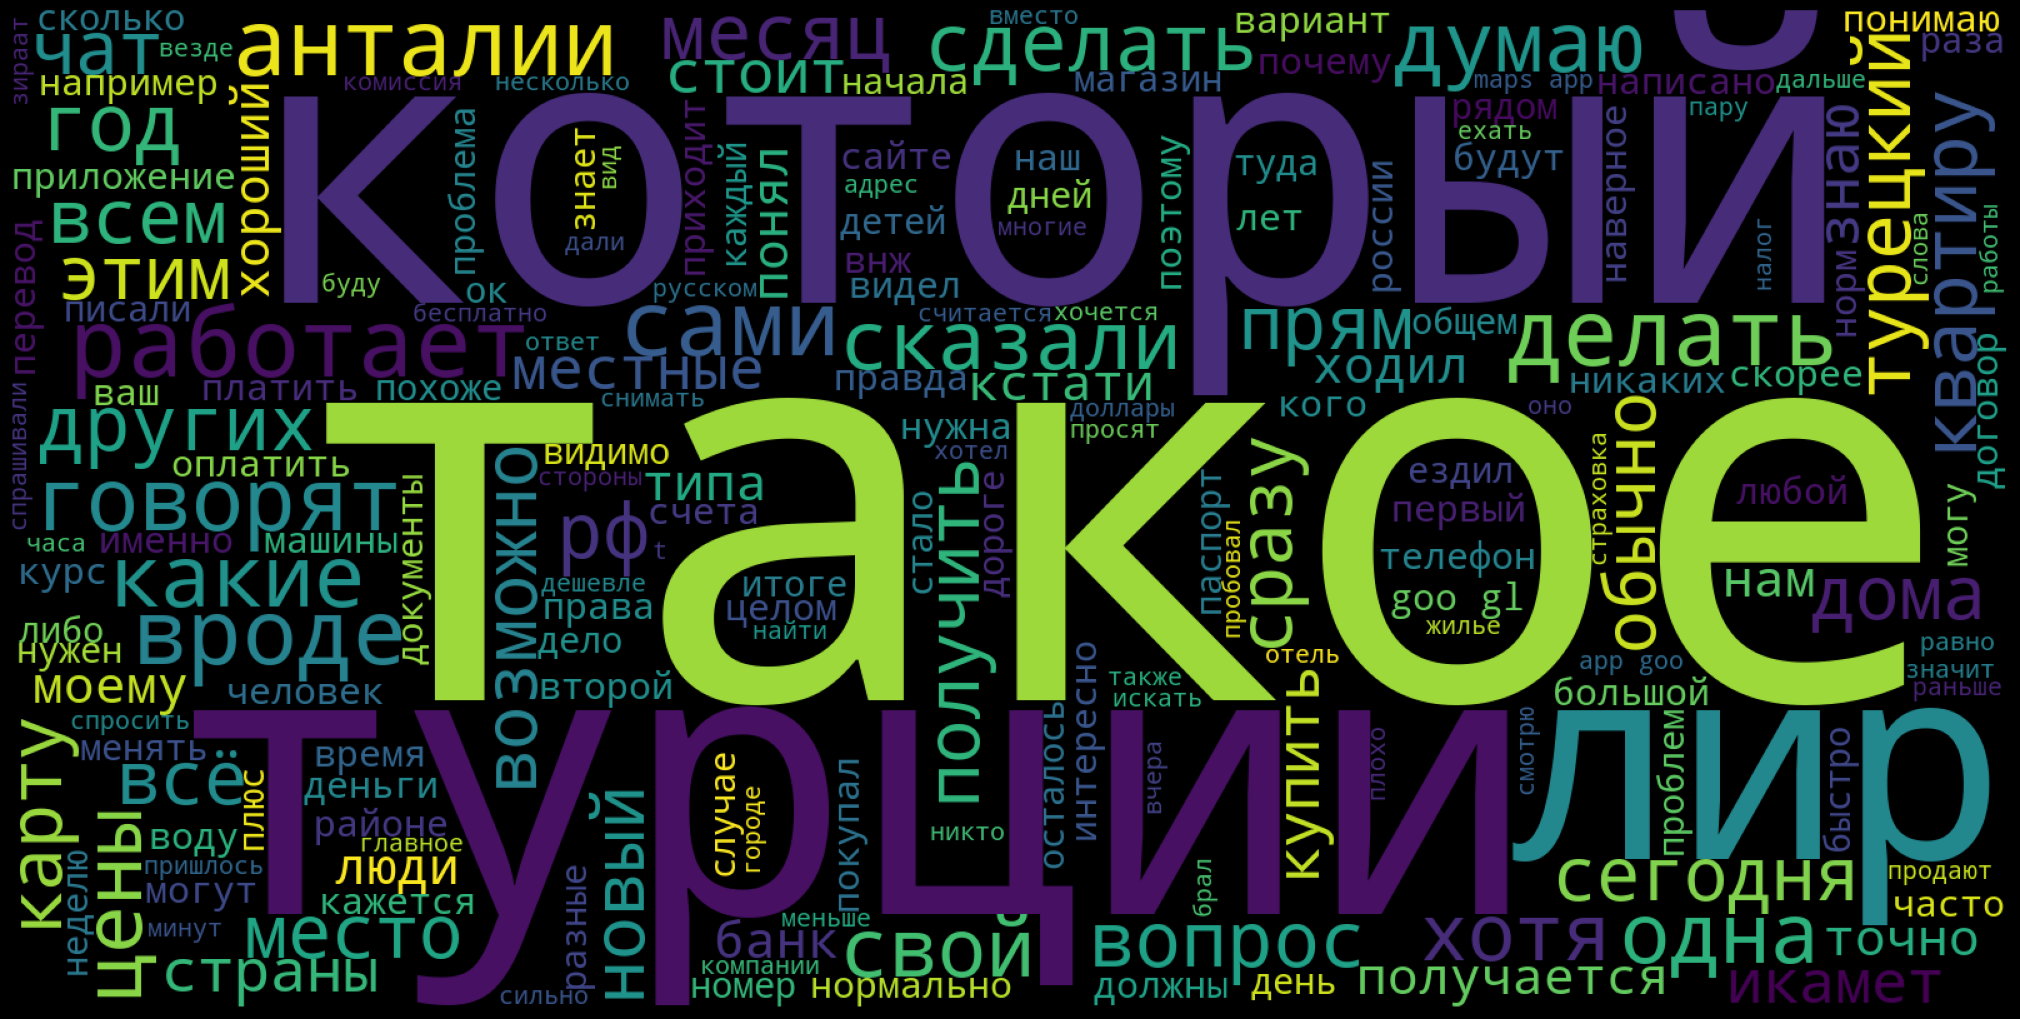

In [117]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
text_raw = " ".join(text)
wordcloud = WordCloud(width=1600, height=800).generate(text_raw)
plt.figure( figsize=(20,10), facecolor='k')
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()